# Notebook for predicting WAR from features via simple linear regression

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler


In [21]:
# Load the by-year data (using retry files with fixed WAR merging)
data_yr = pd.read_csv("data/Hitters_2023-24_byYear_retry.csv")
print(f"Total rows: {len(data_yr)}")
print(f"Years available: {sorted(data_yr['year'].dropna().unique())}")
print(f"Players with 2025 data: {len(data_yr[data_yr['year'] == 2025]['mlbID'].unique())}")
print(f"Rows with WAR: {data_yr['WAR'].notna().sum()} / {len(data_yr)} ({data_yr['WAR'].notna().sum()/len(data_yr)*100:.1f}%)")
data_yr.head()

Total rows: 1850
Years available: [2023.0, 2024.0, 2025.0]
Players with 2025 data: 251
Rows with WAR: 1850 / 1850 (100.0%)


,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,...,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed,Season,WAR
0,CJ Abrams,22,791,Maj-NL,Washington,151,614,563,83,138,...,120.0,WSH,SS,22.0,222.0,13.0,4.22,28.6,2023,3.45
1,Jos\xc3\xa9 Abreu,36,769,Maj-AL,Houston,152,642,584,68,141,...,117.0,HOU,1B,36.0,210.0,NaN,4.76,25.5,2023,-0.09
2,Wilyer Abreu,24,791,Maj-AL,Boston,28,85,76,10,24,...,111.0,BOS,CF,24.0,26.0,NaN,NaN,26.7,2023,0.67
3,Ronald Acu\xc3\xb1a Jr.,25,780,Maj-NL,Atlanta,163,752,657,152,219,...,144.0,ATL,RF,25.0,296.0,18.0,4.35,28.0,2023,8.40
4,Willy Adames,27,788,Maj-NL,Milwaukee,151,646,560,73,124,...,158.0,MIL,SS,27.0,176.0,NaN,4.43,27.6,2023,2.91


In [22]:
# Separate data into 2023-2024 (features) and 2025 (target)
data_2023_2024 = data_yr[data_yr['year'].isin([2023, 2024])].copy()
data_2025 = data_yr[data_yr['year'] == 2025].copy()

print(f"2023-2024 rows: {len(data_2023_2024)}")
print(f"2025 rows: {len(data_2025)}")
print(f"Unique players in 2023-2024: {data_2023_2024['mlbID'].nunique()}")
print(f"Unique players in 2025: {data_2025['mlbID'].nunique()}")

# Find players who have both 2023-2024 and 2025 data
players_with_2025 = set(data_2025['mlbID'].unique())
players_with_2023_2024 = set(data_2023_2024['mlbID'].unique())
common_players = players_with_2025.intersection(players_with_2023_2024)
print(f"Players with both 2023-2024 and 2025 data: {len(common_players)}")

2023-2024 rows: 510
2025 rows: 251
Unique players in 2023-2024: 332
Unique players in 2025: 251
Players with both 2023-2024 and 2025 data: 199


In [23]:
# Identify feature columns - using only specified features
specified_features = [
    'swings_competitive', 'percent_swings_competitive', 'contact', 'avg_bat_speed', 
    'hard_swing_rate', 'squared_up_per_bat_contact', 'squared_up_per_swing', 
    'blast_per_bat_contact', 'blast_per_swing', 'swing_length', 'swords', 
    'batter_run_value', 'whiffs', 'whiff_per_swing', 'batted_ball_events', 
    'batted_ball_event_per_swing', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent', 
    'max_hit_speed', 'avg_hit_speed', 'ev50', 'fbld', 'gb', 'max_distance', 
    'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels', 
    'brl_percent', 'brl_pa', 'pa', 'bip', 'ba', 'est_ba', 'est_ba_minus_ba_diff', 
    'slg', 'est_slg', 'est_slg_minus_slg_diff', 'woba', 'est_woba', 
    'est_woba_minus_woba_diff', 'age', 'competitive_runs', 'bolts', 'hp_to_1b', 
    'sprint_speed'
]

# Get all available columns from the data
all_cols = data_2023_2024.columns.tolist()

# Check which specified features are available (case-insensitive check)
available_features = []
missing_features = []

for feat in specified_features:
    # Try exact match first
    if feat in all_cols:
        available_features.append(feat)
    else:
        # Try case-insensitive match
        matches = [col for col in all_cols if col.lower() == feat.lower()]
        if matches:
            available_features.append(matches[0])  # Use the actual column name
            print(f"Note: Using '{matches[0]}' instead of '{feat}'")
        else:
            missing_features.append(feat)

feature_cols = available_features

print(f"Requested features: {len(specified_features)}")
print(f"Available features: {len(available_features)}")
if missing_features:
    print(f"Missing features ({len(missing_features)}): {missing_features}")
print(f"\nFeatures to use: {feature_cols}")


Requested features: 48
Available features: 48

Features to use: ['swings_competitive', 'percent_swings_competitive', 'contact', 'avg_bat_speed', 'hard_swing_rate', 'squared_up_per_bat_contact', 'squared_up_per_swing', 'blast_per_bat_contact', 'blast_per_swing', 'swing_length', 'swords', 'batter_run_value', 'whiffs', 'whiff_per_swing', 'batted_ball_events', 'batted_ball_event_per_swing', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent', 'max_hit_speed', 'avg_hit_speed', 'ev50', 'fbld', 'gb', 'max_distance', 'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels', 'brl_percent', 'brl_pa', 'pa', 'bip', 'ba', 'est_ba', 'est_ba_minus_ba_diff', 'slg', 'est_slg', 'est_slg_minus_slg_diff', 'woba', 'est_woba', 'est_woba_minus_woba_diff', 'age', 'competitive_runs', 'bolts', 'hp_to_1b', 'sprint_speed']


In [24]:
# For each player, average their 2023-2024 features (handling NaN appropriately)
# We'll average numeric features, but need to be careful about which ones to average vs sum

def average_features_by_player(df, player_id_col='mlbID', feature_cols=None):
    """
    Average features across years for each player.
    Handles NaN by only averaging non-NaN values.
    """
    if feature_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        exclude_cols = ['year', 'Season', 'WAR']
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Group by player and average (NaN values are ignored in mean calculation)
    averaged = df.groupby(player_id_col)[feature_cols].mean().reset_index()
    
    # Also get player name for reference
    if 'Name' in df.columns:
        name_map = df.groupby(player_id_col)['Name'].first().reset_index()
        averaged = averaged.merge(name_map, on=player_id_col, how='left')
    
    return averaged

# Average 2023-2024 features for each player (for training)
features_avg_train = average_features_by_player(data_2023_2024, feature_cols=feature_cols)
print(f"Training features shape (2023-2024 averaged): {features_avg_train.shape}")

# Also average 2023-2024 features for players who have 2025 data (for prediction)
# This will be the same as features_avg_train, but we'll use it for consistency
features_avg = features_avg_train.copy()
print(f"Prediction features shape: {features_avg.shape}")
features_avg.head()


Training features shape (2023-2024 averaged): (332, 50)
Prediction features shape: (332, 50)


,mlbID,swings_competitive,percent_swings_competitive,contact,avg_bat_speed,hard_swing_rate,squared_up_per_bat_contact,squared_up_per_swing,blast_per_bat_contact,blast_per_swing,...,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,age,competitive_runs,bolts,hp_to_1b,sprint_speed,Name
0,408234,285.0,0.904762,225.0,68.187690,0.007018,0.386667,0.305263,0.142222,0.112281,...,-0.0100,0.2990,0.301,-0.0020,40.0,127.0,NaN,5.090,23.1,Miguel Cabrera
1,444482,341.0,0.902116,262.0,72.132424,0.243402,0.297710,0.228739,0.125954,0.096774,...,-0.0190,0.2900,0.309,-0.0190,35.0,195.0,NaN,4.520,27.0,David Peralta
2,453568,507.5,0.898648,413.5,67.141682,0.019685,0.322868,0.264177,0.087987,0.072072,...,0.0405,0.3365,0.322,0.0145,36.5,160.0,NaN,4.375,27.5,Charlie Blackmon
3,455117,307.0,0.902941,203.0,71.736160,0.153094,0.280788,0.185668,0.128079,0.084691,...,-0.0090,0.2660,0.267,-0.0010,36.0,86.0,NaN,5.050,23.2,Mart\xc3\xadn Maldonado
4,456781,310.0,0.901163,222.0,68.095668,0.061290,0.346847,0.248387,0.139640,0.100000,...,-0.0380,0.3380,0.351,-0.0130,35.0,141.0,NaN,4.750,25.4,Donovan Solano


In [25]:
# Prepare training data: 2023-2024 features -> 2023-2024 WAR per 162
# For each player in 2023-2024, calculate their WAR per 162
data_2023_2024_with_war = data_2023_2024.copy()
data_2023_2024_with_war['WAR_per_162'] = (data_2023_2024_with_war['WAR'] / data_2023_2024_with_war['G'].replace(0, pd.NA)) * 162

# Average WAR per 162 across 2023-2024 for each player (for training target)
war_per_162_train = data_2023_2024_with_war.groupby('mlbID')['WAR_per_162'].mean().reset_index()
war_per_162_train.columns = ['mlbID', 'WAR_per_162_train']

# Merge training features with training target
train_data = features_avg_train.merge(war_per_162_train, on='mlbID', how='inner')

print("Training Data (2023-2024):")
print(f"Shape: {train_data.shape}")
print(f"Players: {len(train_data)}")
print(f"\nWAR_per_162 (2023-2024 averaged) stats:")
print(train_data['WAR_per_162_train'].describe())
print(f"\nNaN in training target: {train_data['WAR_per_162_train'].isna().sum()}")

# Prepare test data: 2023-2024 features -> 2025 WAR per 162
# Ensure we have all required columns from data_2025
required_cols = ['mlbID', 'WAR', 'G', 'Name']
# Check which columns actually exist
available_cols = [col for col in required_cols if col in data_2025.columns]
target_2025 = data_2025[available_cols].copy()

# Calculate WAR per 162 games (handle division by zero)
if 'G' in target_2025.columns and 'WAR' in target_2025.columns:
    target_2025['WAR_per_162_2025'] = (target_2025['WAR'] / target_2025['G'].replace(0, pd.NA)) * 162
else:
    raise ValueError("Required columns 'G' or 'WAR' not found in data_2025")

# Merge features with 2025 target (for evaluation)
# Don't include 'G' from target_2025 since features_avg already has 'G' (from 2023-2024)
# We only need WAR_per_162_2025 and WAR for evaluation
merge_cols = ['mlbID', 'WAR_per_162_2025', 'WAR']
test_data = features_avg.merge(target_2025[merge_cols], on='mlbID', how='inner')

print("\nTest Data (2025):")
print(f"Shape: {test_data.shape}")
print(f"Players: {len(test_data)}")
print(f"\nWAR_per_162_2025 stats:")
print(test_data['WAR_per_162_2025'].describe())
print(f"\nNaN in test target: {test_data['WAR_per_162_2025'].isna().sum()}")

train_data.head()


Training Data (2023-2024):
Shape: (332, 51)
Players: 332

WAR_per_162 (2023-2024 averaged) stats:
count    332.000000
mean       2.441736
std        1.955946
min       -2.331220
25%        1.163624
50%        2.378709
75%        3.603778
max        8.577061
Name: WAR_per_162_train, dtype: float64

NaN in training target: 0

Test Data (2025):
Shape: (199, 52)
Players: 199

WAR_per_162_2025 stats:
count    199.000000
mean       2.726722
std        2.137518
min       -2.466486
25%        1.326765
50%        2.392450
75%        3.954027
max        9.883019
Name: WAR_per_162_2025, dtype: float64

NaN in test target: 0


,mlbID,swings_competitive,percent_swings_competitive,contact,avg_bat_speed,hard_swing_rate,squared_up_per_bat_contact,squared_up_per_swing,blast_per_bat_contact,blast_per_swing,...,woba,est_woba,est_woba_minus_woba_diff,age,competitive_runs,bolts,hp_to_1b,sprint_speed,Name,WAR_per_162_train
0,408234,285.0,0.904762,225.0,68.187690,0.007018,0.386667,0.305263,0.142222,0.112281,...,0.2990,0.301,-0.0020,40.0,127.0,NaN,5.090,23.1,Miguel Cabrera,-0.495918
1,444482,341.0,0.902116,262.0,72.132424,0.243402,0.297710,0.228739,0.125954,0.096774,...,0.2900,0.309,-0.0190,35.0,195.0,NaN,4.520,27.0,David Peralta,0.881471
2,453568,507.5,0.898648,413.5,67.141682,0.019685,0.322868,0.264177,0.087987,0.072072,...,0.3365,0.322,0.0145,36.5,160.0,NaN,4.375,27.5,Charlie Blackmon,1.592782
3,455117,307.0,0.902941,203.0,71.736160,0.153094,0.280788,0.185668,0.128079,0.084691,...,0.2660,0.267,-0.0010,36.0,86.0,NaN,5.050,23.2,Mart\xc3\xadn Maldonado,0.420945
4,456781,310.0,0.901163,222.0,68.095668,0.061290,0.346847,0.248387,0.139640,0.100000,...,0.3380,0.351,-0.0130,35.0,141.0,NaN,4.750,25.4,Donovan Solano,1.864748


In [26]:
# Prepare training features and target (2023-2024)
train_data_clean = train_data.dropna(subset=['WAR_per_162_train']).copy()
# Only select feature columns that actually exist in the dataframe
available_train_features = [col for col in feature_cols if col in train_data_clean.columns]
X_train_full = train_data_clean[available_train_features].copy()
y_train_full = train_data_clean['WAR_per_162_train'].copy()

# Prepare test features and target (2025)
test_data_clean = test_data.dropna(subset=['WAR_per_162_2025']).copy()

# Debug: Check which feature columns are missing
missing_features = [col for col in feature_cols if col not in test_data_clean.columns]
if missing_features:
    print(f"Warning: {len(missing_features)} features missing from test_data: {missing_features[:10]}")

# Only select feature columns that actually exist in the dataframe
available_test_features = [col for col in feature_cols if col in test_data_clean.columns]
X_test = test_data_clean[available_test_features].copy()
y_test = test_data_clean['WAR_per_162_2025'].copy()

# Ensure both have the same features (use intersection)
common_features = list(set(available_train_features) & set(available_test_features))
X_train_full = X_train_full[common_features].copy()
X_test = X_test[common_features].copy()

print(f"Training set: {X_train_full.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Common features used: {len(common_features)}")
if len(common_features) < len(feature_cols):
    missing = set(feature_cols) - set(common_features)
    print(f"Features excluded (not in both datasets): {missing}")

# Handle NaN in features - we'll use median imputation for missing values
from sklearn.impute import SimpleImputer

# Fit imputer on training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_full),
    columns=X_train_full.columns,
    index=X_train_full.index
)

# Transform test data with the same imputer
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"\nTraining NaN after imputation: {X_train_imputed.isna().sum().sum()}")
print(f"Test NaN after imputation: {X_test_imputed.isna().sum().sum()}")

# Scale features (important for regularization)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

# For consistency with variable names in later cells
# Use scaled features for regularized models, original for comparison
X_train = X_train_scaled
y_train = y_train_full
X_test = X_test_scaled
X_train_unscaled = X_train_imputed  # Keep unscaled for LinearRegression comparison
X_test_unscaled = X_test_imputed


Training set: 332 samples
Test set: 199 samples
Common features used: 48

Training NaN after imputation: 0
Test NaN after imputation: 0


In [27]:
# Train models with regularization on 2023-2024 data
# Model learns: 2023-2024 features -> 2023-2024 WAR per 162
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Baseline: Linear Regression (no regularization) - use unscaled data
lr_model = LinearRegression()
lr_model.fit(X_train_unscaled, y_train)
y_train_pred_lr = lr_model.predict(X_train_unscaled)
y_test_pred_lr = lr_model.predict(X_test_unscaled)

# Ridge Regression (L2 regularization)
print("Tuning Ridge Regression...")
ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
ridge_model = ridge_grid.best_estimator_
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)
print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")

# Lasso Regression (L1 regularization)
print("Tuning Lasso Regression...")
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)
lasso_model = lasso_grid.best_estimator_
y_train_pred_lasso = lasso_model.predict(X_train)
y_test_pred_lasso = lasso_model.predict(X_test)
print(f"Best Lasso alpha: {lasso_grid.best_params_['alpha']}")

# ElasticNet (L1 + L2 regularization)
print("Tuning ElasticNet...")
elasticnet_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elasticnet_grid = GridSearchCV(ElasticNet(max_iter=10000), elasticnet_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elasticnet_grid.fit(X_train, y_train)
elasticnet_model = elasticnet_grid.best_estimator_
y_train_pred_elasticnet = elasticnet_model.predict(X_train)
y_test_pred_elasticnet = elasticnet_model.predict(X_test)
print(f"Best ElasticNet alpha: {elasticnet_grid.best_params_['alpha']}, l1_ratio: {elasticnet_grid.best_params_['l1_ratio']}")

# Calculate metrics for all models
models = {
    'Linear Regression': (y_train_pred_lr, y_test_pred_lr),
    'Ridge': (y_train_pred_ridge, y_test_pred_ridge),
    'Lasso': (y_train_pred_lasso, y_test_pred_lasso),
    'ElasticNet': (y_train_pred_elasticnet, y_test_pred_elasticnet)
}

print("\n" + "="*70)
print("Model Performance Comparison:")
print("="*70)

results = []
for name, (y_train_pred, y_test_pred) in models.items():
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2
    })
    
    print(f"\n{name}:")
    print(f"  Training: RMSE={train_rmse:.3f}, MAE={train_mae:.3f}, R²={train_r2:.3f}")
    print(f"  Test:     RMSE={test_rmse:.3f}, MAE={test_mae:.3f}, R²={test_r2:.3f}")

# Select best model based on test RMSE
results_df = pd.DataFrame(results)
best_model_name = results_df.loc[results_df['Test_RMSE'].idxmin(), 'Model']
print(f"\n{'='*70}")
print(f"Best model (lowest test RMSE): {best_model_name}")
print(f"{'='*70}")

# Store best model predictions for later use
if best_model_name == 'Linear Regression':
    best_model = lr_model
    y_train_pred = y_train_pred_lr
    y_test_pred = y_test_pred_lr
elif best_model_name == 'Ridge':
    best_model = ridge_model
    y_train_pred = y_train_pred_ridge
    y_test_pred = y_test_pred_ridge
elif best_model_name == 'Lasso':
    best_model = lasso_model
    y_train_pred = y_train_pred_lasso
    y_test_pred = y_test_pred_lasso
else:  # ElasticNet
    best_model = elasticnet_model
    y_train_pred = y_train_pred_elasticnet
    y_test_pred = y_test_pred_elasticnet

# Also keep lr_model for backward compatibility
lr_model = best_model


Tuning Ridge Regression...
Best Ridge alpha: 100.0
Tuning Lasso Regression...
Best Lasso alpha: 0.1
Tuning ElasticNet...
Best ElasticNet alpha: 0.1, l1_ratio: 0.9

Model Performance Comparison:

Linear Regression:
  Training: RMSE=1.092, MAE=0.878, R²=0.688
  Test:     RMSE=2.010, MAE=1.583, R²=0.111

Ridge:
  Training: RMSE=1.155, MAE=0.908, R²=0.650
  Test:     RMSE=2.016, MAE=1.595, R²=0.106

Lasso:
  Training: RMSE=1.172, MAE=0.915, R²=0.640
  Test:     RMSE=2.035, MAE=1.603, R²=0.089

ElasticNet:
  Training: RMSE=1.168, MAE=0.910, R²=0.642
  Test:     RMSE=2.033, MAE=1.601, R²=0.091

Best model (lowest test RMSE): Linear Regression


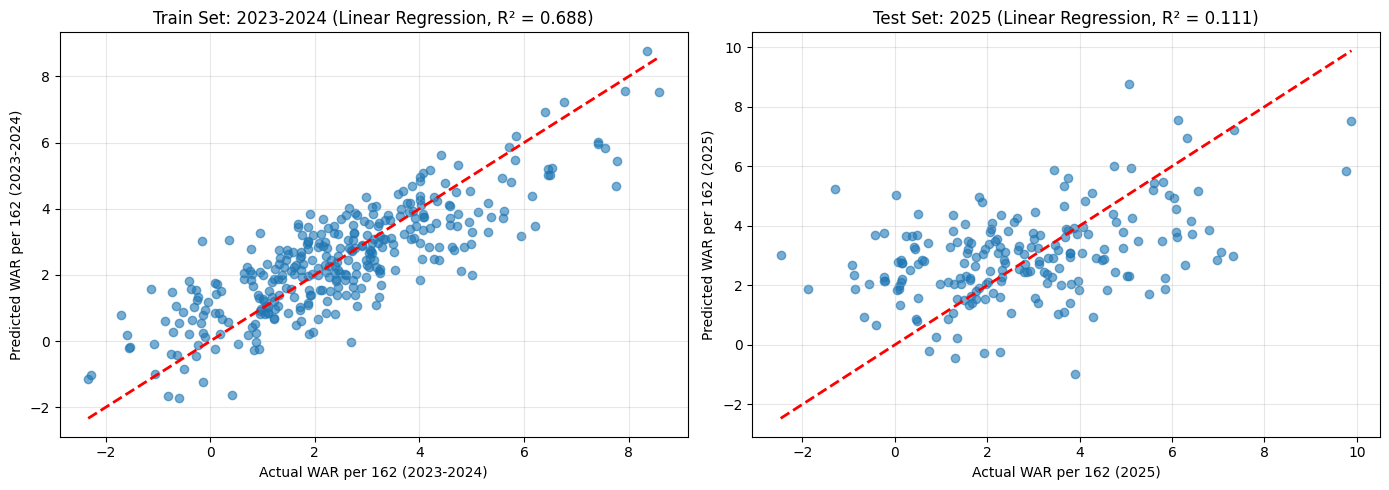

In [28]:
# Visualize predictions vs actual (using best model)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set (2023-2024)
axes[0].scatter(y_train, y_train_pred, alpha=0.6)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual WAR per 162 (2023-2024)')
axes[0].set_ylabel('Predicted WAR per 162 (2023-2024)')
axes[0].set_title(f'Train Set: 2023-2024 ({best_model_name}, R² = {train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set (2025)
axes[1].scatter(y_test, y_test_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual WAR per 162 (2025)')
axes[1].set_ylabel('Predicted WAR per 162 (2025)')
axes[1].set_title(f'Test Set: 2025 ({best_model_name}, R² = {test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [29]:
# Get feature importance (coefficients) from best model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_model.coef_
})
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print(f"Top 20 Most Important Features (by absolute coefficient) - {best_model_name}:")
print(feature_importance.head(20))


Top 20 Most Important Features (by absolute coefficient) - Linear Regression:
                        feature  coefficient  abs_coefficient
37                     est_woba    32.774834        32.774834
31         squared_up_per_swing    29.559937        29.559937
22                       est_ba   -20.388553        20.388553
16   percent_swings_competitive    20.127784        20.127784
32     est_woba_minus_woba_diff   -19.163768        19.163768
34         est_ba_minus_ba_diff    18.503196        18.503196
33   squared_up_per_bat_contact   -18.368025        18.368025
38                         woba    13.611066        13.611066
21              whiff_per_swing    12.516638        12.516638
9         blast_per_bat_contact    10.634099        10.634099
12       est_slg_minus_slg_diff    10.408157        10.408157
18                          slg    10.406152        10.406152
29              blast_per_swing    -9.093152         9.093152
39  batted_ball_event_per_swing     6.213831         6

In [30]:
# Make predictions for all players with 2023-2024 data (even if they don't have 2025 data)
# Model was trained on 2023-2024, now predicting 2025 WAR per 162

# Prepare all players' features (2023-2024 averaged)
# Use the same feature columns that were used for training
all_players_features = features_avg[common_features].copy()
all_players_features_imputed = pd.DataFrame(
    imputer.transform(all_players_features),
    columns=all_players_features.columns,
    index=all_players_features.index
)

# Scale features if using regularized model (best_model), otherwise use unscaled
if best_model_name == 'Linear Regression':
    all_players_features_processed = all_players_features_imputed
else:
    all_players_features_processed = pd.DataFrame(
        scaler.transform(all_players_features_imputed),
        columns=all_players_features_imputed.columns,
        index=all_players_features_imputed.index
    )

# Make predictions (these are WAR per 162 for 2025)
all_predictions = best_model.predict(all_players_features_processed)

# Create results dataframe
predictions_df = features_avg[['mlbID', 'Name']].copy()
predictions_df['predicted_WAR_per_162_2025'] = all_predictions

# Recreate target_2025 to ensure it has all needed columns (in case cell 6 wasn't run)
target_2025_for_merge = data_2025[['mlbID', 'WAR', 'G', 'Name']].copy()
target_2025_for_merge['WAR_per_162_2025'] = (target_2025_for_merge['WAR'] / target_2025_for_merge['G'].replace(0, pd.NA)) * 162

# Merge with actual 2025 WAR per 162 if available
# Don't include 'G' in merge since predictions_df (from features_avg) already has 'G' from 2023-2024
# This avoids G_x/G_y column name conflict
merge_cols = ['mlbID', 'WAR_per_162_2025', 'WAR']
predictions_df = predictions_df.merge(
    target_2025_for_merge[merge_cols], 
    on='mlbID', 
    how='left'
)

# Add G_2025 separately if needed (rename to avoid conflict with G from features_avg)
if 'G' in target_2025_for_merge.columns:
    g_2025_data = target_2025_for_merge[['mlbID', 'G']].copy()
    g_2025_data = g_2025_data.rename(columns={'G': 'G_2025'})
    predictions_df = predictions_df.merge(g_2025_data, on='mlbID', how='left')

# Sort by predicted WAR per 162
predictions_df = predictions_df.sort_values('predicted_WAR_per_162_2025', ascending=False)

# Print results - include G from features_avg and G_2025 if available
print_cols = ['Name', 'predicted_WAR_per_162_2025', 'WAR_per_162_2025', 'WAR']
if 'G' in predictions_df.columns:
    print_cols.append('G')
if 'G_2025' in predictions_df.columns:
    print_cols.append('G_2025')

print("Top 20 Predicted WAR per 162 2025:")
print(predictions_df.head(20)[print_cols].to_string(index=False))

print(f"\nTotal players with predictions: {len(predictions_df)}")
print(f"Players with actual 2025 WAR per 162: {predictions_df['WAR_per_162_2025'].notna().sum()}")


Top 20 Predicted WAR per 162 2025:
                      Name  predicted_WAR_per_162_2025  WAR_per_162_2025   WAR  G_2025
   Ronald Acu\xc3\xb1a Jr.                    8.775429          5.064632  2.97    95.0
             Shohei Ohtani                    7.556476          6.128229  6.62   175.0
               Aaron Judge                    7.518898          9.883019  9.70   159.0
            Bobby Witt Jr.                    7.231632          7.336433  7.11   157.0
                 Juan Soto                    6.934225          6.318000  6.24   160.0
            Yordan Alvarez                    6.204795               NaN   NaN     NaN
              Mookie Betts                    6.022971          4.743593  4.89   167.0
               Kyle Tucker                    5.953509          5.118750  4.55   144.0
           Freddie Freeman                    5.863746          3.447439  3.49   164.0
              Corey Seager                    5.843839          9.767647  6.15   102.0
        

In [31]:
# Compare predictions vs actual for players with 2025 data
# This is the same as the test set evaluation, but showing individual player errors
comparison = predictions_df[predictions_df['WAR_per_162_2025'].notna()].copy()
comparison['error'] = comparison['predicted_WAR_per_162_2025'] - comparison['WAR_per_162_2025']
comparison['abs_error'] = np.abs(comparison['error'])

print("Players with largest prediction errors (2025):")
print(comparison.nlargest(10, 'abs_error')[['Name', 'predicted_WAR_per_162_2025', 'WAR_per_162_2025', 'error']].to_string(index=False))

print(f"\nMean Absolute Error (all players with 2025 data): {comparison['abs_error'].mean():.3f}")
print(f"RMSE (all players with 2025 data): {np.sqrt((comparison['error']**2).mean()):.3f}")
print(f"\nNote: Model trained on 2023-2024 WAR per 162, evaluated on 2025 WAR per 162")


Players with largest prediction errors (2025):
              Name  predicted_WAR_per_162_2025  WAR_per_162_2025     error
       Nolan Jones                    5.227337         -1.286471  6.513807
     Jordan Walker                    3.036795         -2.466486  5.503281
       Matt McLain                    5.026411          0.032617  4.993794
        Brett Baty                   -0.987910          3.905581 -4.893491
Jeremy Pe\xc3\xb1a                    2.981070          7.309440 -4.328370
       Cal Raleigh                    2.838774          6.982105 -4.143331
         JJ Bleday                    3.679633         -0.429796  4.109428
      Mark Vientos                    3.766607         -0.227603  3.994210
     Maikel Garcia                    1.869112          5.842125 -3.973013
   Geraldo Perdomo                    3.128716          7.063602 -3.934886

Mean Absolute Error (all players with 2025 data): 1.583
RMSE (all players with 2025 data): 2.010

Note: Model trained on 2023-2

In [32]:
# Show top 20 best predictions (smallest absolute error)
print("Top 20 Best Predictions (smallest absolute error, 2025):")
best_predictions = comparison.nsmallest(20, 'abs_error')[['Name', 'predicted_WAR_per_162_2025', 'WAR_per_162_2025', 'error', 'abs_error']]
print(best_predictions.to_string(index=False))


Top 20 Best Predictions (smallest absolute error, 2025):
                 Name  predicted_WAR_per_162_2025  WAR_per_162_2025     error  abs_error
         Ryan Jeffers                    1.640528          1.647227 -0.006699   0.006699
      Xander Bogaerts                    2.292157          2.319281 -0.027124   0.027124
        Tyrone Taylor                    1.525663          1.490973  0.034689   0.034689
           Colt Keith                    1.800011          1.756901  0.043109   0.043109
      Brendan Donovan                    3.637933          3.693051 -0.055117   0.055117
          Bo Bichette                    3.932375          3.872466  0.059909   0.059909
        Nolan Arenado                    2.044236          1.971509  0.072727   0.072727
          Steven Kwan                    3.847796          3.759623  0.088174   0.088174
Mauricio Dub\xc3\xb3n                    2.102423          2.009774  0.092649   0.092649
        Jorge Polanco                    2.718784    

In [33]:
# Identify breakout players: largest jumps in WAR per 162 from 2024 to 2025
# Extract 2024 data
data_2024 = data_yr[data_yr['year'] == 2024].copy()

# Calculate WAR per 162 for 2024
data_2024['WAR_per_162_2024'] = (data_2024['WAR'] / data_2024['G'].replace(0, pd.NA)) * 162

# Get 2024 WAR per 162 for each player
war_2024 = data_2024[['mlbID', 'Name', 'WAR_per_162_2024', 'WAR', 'G']].copy()

# Get 2025 WAR per 162 (already calculated in earlier cells)
war_2025 = data_2025[['mlbID', 'Name', 'WAR', 'G']].copy()
war_2025['WAR_per_162_2025'] = (war_2025['WAR'] / war_2025['G'].replace(0, pd.NA)) * 162

# Merge 2024 and 2025 data to find players with both
breakout_comparison = war_2024.merge(
    war_2025[['mlbID', 'WAR_per_162_2025', 'WAR', 'G']],
    on='mlbID',
    how='inner',
    suffixes=('_2024', '_2025')
)

# Calculate the jump (difference) in WAR per 162
breakout_comparison['war_jump'] = breakout_comparison['WAR_per_162_2025'] - breakout_comparison['WAR_per_162_2024']

# Get model predictions for these players
breakout_comparison = breakout_comparison.merge(
    predictions_df[['mlbID', 'predicted_WAR_per_162_2025']],
    on='mlbID',
    how='left'
)

# Calculate prediction error for breakout players
breakout_comparison['prediction_error'] = breakout_comparison['predicted_WAR_per_162_2025'] - breakout_comparison['WAR_per_162_2025']
breakout_comparison['abs_prediction_error'] = np.abs(breakout_comparison['prediction_error'])

# Sort by largest WAR jump
breakout_comparison = breakout_comparison.sort_values('war_jump', ascending=False)

print("Top 20 Breakout Players (Largest WAR per 162 Jump from 2024 to 2025):")
print("="*100)
breakout_display = breakout_comparison.head(20)[[
    'Name', 
    'WAR_per_162_2024', 
    'WAR_per_162_2025', 
    'war_jump',
    'predicted_WAR_per_162_2025',
    'prediction_error',
    'abs_prediction_error'
]].copy()
breakout_display.columns = [
    'Name',
    'WAR/162 (2024)',
    'WAR/162 (2025 Actual)',
    'Jump (2025-2024)',
    'WAR/162 (2025 Predicted)',
    'Prediction Error',
    'Abs Error'
]
print(breakout_display.to_string(index=False))

print(f"\nSummary Statistics for Breakout Players:")
print(f"  Mean WAR jump: {breakout_comparison['war_jump'].mean():.3f}")
print(f"  Mean prediction error: {breakout_comparison['prediction_error'].mean():.3f}")
print(f"  Mean absolute prediction error: {breakout_comparison['abs_prediction_error'].mean():.3f}")
print(f"  Players with positive jumps: {(breakout_comparison['war_jump'] > 0).sum()}")
print(f"  Players with negative jumps: {(breakout_comparison['war_jump'] < 0).sum()}")


Top 20 Breakout Players (Largest WAR per 162 Jump from 2024 to 2025):
                Name  WAR/162 (2024)  WAR/162 (2025 Actual)  Jump (2025-2024)  WAR/162 (2025 Predicted)  Prediction Error  Abs Error
       Maikel Garcia        1.192638               5.842125          4.649487                  1.869112         -3.973013   3.973013
     George Springer        1.184276               5.026154          3.841878                  2.304503         -2.721650   2.721650
      Harrison Bader        0.985135               4.283758          3.298623                  0.924433         -3.359325   3.359325
        Corey Seager        6.532683               9.767647          3.234964                  5.843839         -3.923808   3.923808
  Jeremy Pe\xc3\xb1a        4.156981               7.309440          3.152459                  2.981070         -4.328370   4.328370
      Corbin Carroll        3.445063               6.559301          3.114237                  5.182771         -1.376530   1.376530

In [34]:
# Identify players who got worse: largest declines in WAR per 162 from 2024 to 2025
# Use the breakout_comparison data from previous cell (already has all the calculations)
# Filter for negative jumps and sort by most negative (biggest decline)
decline_players = breakout_comparison[breakout_comparison['war_jump'] < 0].copy()
decline_players = decline_players.sort_values('war_jump', ascending=True)  # Most negative first

print("Top 20 Players Who Declined Most (Largest WAR per 162 Drop from 2024 to 2025):")
print("="*100)
decline_display = decline_players.head(20)[[
    'Name', 
    'WAR_per_162_2024', 
    'WAR_per_162_2025', 
    'war_jump',
    'predicted_WAR_per_162_2025',
    'prediction_error',
    'abs_prediction_error'
]].copy()
decline_display.columns = [
    'Name',
    'WAR/162 (2024)',
    'WAR/162 (2025 Actual)',
    'Decline (2025-2024)',
    'WAR/162 (2025 Predicted)',
    'Prediction Error',
    'Abs Error'
]
print(decline_display.to_string(index=False))

print(f"\nSummary Statistics for Declining Players:")
print(f"  Mean WAR decline: {decline_players['war_jump'].mean():.3f}")
print(f"  Mean prediction error: {decline_players['prediction_error'].mean():.3f}")
print(f"  Mean absolute prediction error: {decline_players['abs_prediction_error'].mean():.3f}")
print(f"  Total declining players: {len(decline_players)}")


Top 20 Players Who Declined Most (Largest WAR per 162 Drop from 2024 to 2025):
             Name  WAR/162 (2024)  WAR/162 (2025 Actual)  Decline (2025-2024)  WAR/162 (2025 Predicted)  Prediction Error  Abs Error
    Carlos Correa        6.875581               1.642500            -5.233081                  3.413231          1.770731   1.770731
      Kyle Tucker        9.497250               5.118750            -4.378500                  5.953509          0.834759   0.834759
    Brenton Doyle        4.392483               0.058696            -4.333788                  1.847225          1.788530   1.788530
     Mark Vientos        4.089194              -0.227603            -4.316797                  3.766607          3.994210   3.994210
     Jarren Duran        8.788500               4.718250            -4.070250                  4.389638         -0.328612   0.328612
     Riley Greene        6.086250               2.110909            -3.975341                  4.098305          1.987396  

In [35]:
# Feature Selection Analysis: Can we improve performance by removing features?
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score

print("="*80)
print("FEATURE SELECTION ANALYSIS")
print("="*80)

# 1. Check which features Lasso sets to zero (if Lasso was used)
if 'lasso_model' in locals():
    lasso_coefs = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': lasso_model.coef_,
        'abs_coefficient': np.abs(lasso_model.coef_)
    })
    lasso_zero_features = lasso_coefs[lasso_coefs['coefficient'] == 0]['feature'].tolist()
    lasso_nonzero_features = lasso_coefs[lasso_coefs['coefficient'] != 0]['feature'].tolist()
    print(f"\n1. Lasso Feature Selection:")
    print(f"   Features set to zero by Lasso: {len(lasso_zero_features)}")
    print(f"   Features kept by Lasso: {len(lasso_nonzero_features)}")
    if len(lasso_zero_features) > 0:
        print(f"   Sample zeroed features: {lasso_zero_features[:10]}")

# 2. Check for highly correlated features (multicollinearity)
print(f"\n2. Correlation Analysis:")
corr_matrix = X_train.corr().abs()
# Find pairs of highly correlated features (threshold > 0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))
print(f"   Highly correlated feature pairs (r > 0.9): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print(f"   Sample pairs: {high_corr_pairs[:5]}")

# 3. Recursive Feature Elimination (RFE) with Ridge
print(f"\n3. Recursive Feature Elimination (RFE):")
print("   Testing different numbers of features...")

# Try different numbers of features
n_features_to_test = [20, 30, 40, 50, len(X_train.columns)]
rfe_results = []

for n_features in n_features_to_test:
    if n_features > len(X_train.columns):
        continue
    
    # Use Ridge as estimator for RFE
    rfe_estimator = Ridge(alpha=ridge_model.alpha if 'ridge_model' in locals() else 1.0)
    rfe = RFE(estimator=rfe_estimator, n_features_to_select=n_features, step=1)
    rfe.fit(X_train, y_train)
    
    # Get selected features
    selected_features = X_train.columns[rfe.support_].tolist()
    X_train_rfe = X_train[selected_features]
    X_test_rfe = X_test[selected_features]
    
    # Train model with selected features
    rfe_model = Ridge(alpha=ridge_model.alpha if 'ridge_model' in locals() else 1.0)
    rfe_model.fit(X_train_rfe, y_train)
    
    # Evaluate
    y_train_pred_rfe = rfe_model.predict(X_train_rfe)
    y_test_pred_rfe = rfe_model.predict(X_test_rfe)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rfe))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rfe))
    test_r2 = r2_score(y_test, y_test_pred_rfe)
    
    rfe_results.append({
        'n_features': n_features,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    })
    
    print(f"   {n_features:2d} features: Test RMSE = {test_rmse:.3f}, Test R² = {test_r2:.3f}")

rfe_results_df = pd.DataFrame(rfe_results)
best_rfe = rfe_results_df.loc[rfe_results_df['test_rmse'].idxmin()]

print(f"\n   Best RFE result: {int(best_rfe['n_features'])} features")
print(f"   Test RMSE: {best_rfe['test_rmse']:.3f}, Test R²: {best_rfe['test_r2']:.3f}")

# 4. SelectKBest (univariate feature selection)
print(f"\n4. SelectKBest (Univariate Feature Selection):")
print("   Testing different numbers of top features...")

kbest_results = []
for k in [20, 30, 40, 50, len(X_train.columns)]:
    if k > len(X_train.columns):
        continue
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_kbest = selector.fit_transform(X_train, y_train)
    X_test_kbest = selector.transform(X_test)
    selected_features_kbest = X_train.columns[selector.get_support()].tolist()
    
    # Train model
    kbest_model = Ridge(alpha=ridge_model.alpha if 'ridge_model' in locals() else 1.0)
    kbest_model.fit(X_train_kbest, y_train)
    
    # Evaluate
    y_train_pred_kbest = kbest_model.predict(X_train_kbest)
    y_test_pred_kbest = kbest_model.predict(X_test_kbest)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_kbest))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_kbest))
    test_r2 = r2_score(y_test, y_test_pred_kbest)
    
    kbest_results.append({
        'n_features': k,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    })
    
    print(f"   {k:2d} features: Test RMSE = {test_rmse:.3f}, Test R² = {test_r2:.3f}")

kbest_results_df = pd.DataFrame(kbest_results)
best_kbest = kbest_results_df.loc[kbest_results_df['test_rmse'].idxmin()]

print(f"\n   Best SelectKBest result: {int(best_kbest['n_features'])} features")
print(f"   Test RMSE: {best_kbest['test_rmse']:.3f}, Test R²: {best_kbest['test_r2']:.3f}")

# 5. Compare with baseline (all features)
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
baseline_test_r2 = r2_score(y_test, y_test_pred)

print(f"\n5. Comparison with Baseline (All {len(X_train.columns)} Features):")
print(f"   Baseline Test RMSE: {baseline_test_rmse:.3f}, Test R²: {baseline_test_r2:.3f}")
print(f"\n   Best RFE improvement: {((baseline_test_rmse - best_rfe['test_rmse']) / baseline_test_rmse * 100):.2f}% RMSE reduction")
print(f"   Best SelectKBest improvement: {((baseline_test_rmse - best_kbest['test_rmse']) / baseline_test_rmse * 100):.2f}% RMSE reduction")

print("\n" + "="*80)
print("RECOMMENDATION:")
if best_rfe['test_rmse'] < baseline_test_rmse or best_kbest['test_rmse'] < baseline_test_rmse:
    best_method = 'RFE' if best_rfe['test_rmse'] < best_kbest['test_rmse'] else 'SelectKBest'
    best_n = int(best_rfe['n_features']) if best_method == 'RFE' else int(best_kbest['n_features'])
    print(f"   Consider using {best_method} with {best_n} features for potentially better performance.")
else:
    print(f"   Current feature set appears optimal. Feature selection doesn't improve test performance.")
print("="*80)


FEATURE SELECTION ANALYSIS

1. Lasso Feature Selection:
   Features set to zero by Lasso: 38
   Features kept by Lasso: 10
   Sample zeroed features: ['swings_competitive', 'hard_swing_rate', 'ev95percent', 'bolts', 'gb', 'est_slg', 'ev50', 'max_distance', 'blast_per_bat_contact', 'avg_distance']

2. Correlation Analysis:
   Highly correlated feature pairs (r > 0.9): 20
   Sample pairs: [('swings_competitive', 'batted_ball_events', 0.9281229688075102), ('swings_competitive', 'contact', 0.9731382111480587), ('hard_swing_rate', 'avg_bat_speed', 0.9254554564197346), ('bip', 'pa', 0.9032579196481167), ('bip', 'attempts', 1.0)]

3. Recursive Feature Elimination (RFE):
   Testing different numbers of features...
   20 features: Test RMSE = 2.027, Test R² = 0.096
   30 features: Test RMSE = 2.023, Test R² = 0.100
   40 features: Test RMSE = 2.017, Test R² = 0.105
   48 features: Test RMSE = 2.016, Test R² = 0.106

   Best RFE result: 48 features
   Test RMSE: 2.016, Test R²: 0.106

4. SelectK

In [36]:
# Neural Network Analysis: Can deeper networks improve performance?
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')  # Suppress convergence warnings

print("="*80)
print("NEURAL NETWORK ANALYSIS")
print("="*80)

# Baseline: Current best model performance
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
baseline_test_r2 = r2_score(y_test, y_test_pred)
print(f"\nBaseline (Current Best Model - {best_model_name}):")
print(f"  Test RMSE: {baseline_test_rmse:.3f}")
print(f"  Test R²: {baseline_test_r2:.3f}")

# Test different neural network architectures
nn_configs = [
    # (name, hidden_layer_sizes, alpha, max_iter)
    ("Shallow (1 layer, 50 neurons)", (50,), 0.01, 1000),
    ("Shallow (1 layer, 100 neurons)", (100,), 0.01, 1000),
    ("Medium (2 layers, 50-25)", (50, 25), 0.01, 1000),
    ("Medium (2 layers, 100-50)", (100, 50), 0.01, 1000),
    ("Deep (3 layers, 100-50-25)", (100, 50, 25), 0.01, 1000),
    ("Deep (3 layers, 150-75-50)", (150, 75, 50), 0.01, 1000),
    ("Deeper (4 layers, 100-75-50-25)", (100, 75, 50, 25), 0.01, 1000),
    ("Deeper (4 layers, 150-100-75-50)", (150, 100, 75, 50), 0.01, 1000),
    ("Very Deep (5 layers, 100-75-50-25-10)", (100, 75, 50, 25, 10), 0.01, 1000),
]

print(f"\nTesting Neural Network Architectures:")
print("-"*80)

nn_results = []

for name, hidden_layers, alpha, max_iter in nn_configs:
    try:
        # Create MLP with early stopping
        mlp = MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            activation='relu',
            solver='adam',
            alpha=alpha,  # L2 regularization
            batch_size='auto',
            learning_rate='adaptive',
            learning_rate_init=0.001,
            max_iter=max_iter,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            tol=1e-4,
            random_state=42,
            verbose=False
        )
        
        # Train
        mlp.fit(X_train, y_train)
        
        # Predictions
        y_train_pred_nn = mlp.predict(X_train)
        y_test_pred_nn = mlp.predict(X_test)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))
        train_mae = mean_absolute_error(y_train, y_train_pred_nn)
        test_mae = mean_absolute_error(y_test, y_test_pred_nn)
        train_r2 = r2_score(y_train, y_train_pred_nn)
        test_r2 = r2_score(y_test, y_test_pred_nn)
        
        nn_results.append({
            'name': name,
            'layers': len(hidden_layers),
            'total_neurons': sum(hidden_layers),
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'n_iter': mlp.n_iter_
        })
        
        improvement = ((baseline_test_rmse - test_rmse) / baseline_test_rmse * 100)
        status = "✓" if test_rmse < baseline_test_rmse else "✗"
        
        print(f"{status} {name:45s} | Test RMSE: {test_rmse:.3f} | Test R²: {test_r2:.3f} | "
              f"Improvement: {improvement:+.2f}% | Iterations: {mlp.n_iter_}")
        
    except Exception as e:
        print(f"✗ {name:45s} | Failed: {str(e)[:50]}")

nn_results_df = pd.DataFrame(nn_results)

if len(nn_results_df) > 0:
    # Find best NN
    best_nn = nn_results_df.loc[nn_results_df['test_rmse'].idxmin()]
    
    print("\n" + "="*80)
    print("BEST NEURAL NETWORK:")
    print(f"  Architecture: {best_nn['name']}")
    print(f"  Test RMSE: {best_nn['test_rmse']:.3f}")
    print(f"  Test R²: {best_nn['test_r2']:.3f}")
    print(f"  Test MAE: {best_nn['test_mae']:.3f}")
    print(f"  Improvement over baseline: {((baseline_test_rmse - best_nn['test_rmse']) / baseline_test_rmse * 100):.2f}%")
    
    print("\n" + "="*80)
    print("COMPARISON SUMMARY:")
    print(f"  Baseline ({best_model_name}):     Test RMSE = {baseline_test_rmse:.3f}, Test R² = {baseline_test_r2:.3f}")
    print(f"  Best Neural Network:              Test RMSE = {best_nn['test_rmse']:.3f}, Test R² = {best_nn['test_r2']:.3f}")
    
    if best_nn['test_rmse'] < baseline_test_rmse:
        print(f"\n  ✓ Neural network improves performance by {((baseline_test_rmse - best_nn['test_rmse']) / baseline_test_rmse * 100):.2f}%")
        print(f"  Consider using: {best_nn['name']}")
    else:
        print(f"\n  ✗ Neural network does not improve over baseline")
        print(f"  Current linear model ({best_model_name}) performs better")
    
    # Show top 3 NN architectures
    print("\n" + "-"*80)
    print("Top 3 Neural Network Architectures:")
    top3_nn = nn_results_df.nsmallest(3, 'test_rmse')[['name', 'test_rmse', 'test_r2', 'layers', 'total_neurons']]
    for idx, row in top3_nn.iterrows():
        print(f"  {row['name']:45s} | RMSE: {row['test_rmse']:.3f} | R²: {row['test_r2']:.3f} | "
              f"Layers: {int(row['layers'])} | Neurons: {int(row['total_neurons'])}")
    
    print("="*80)


NEURAL NETWORK ANALYSIS

Baseline (Current Best Model - Linear Regression):
  Test RMSE: 2.010
  Test R²: 0.111

Testing Neural Network Architectures:
--------------------------------------------------------------------------------
✗ Shallow (1 layer, 50 neurons)                 | Test RMSE: 2.014 | Test R²: 0.108 | Improvement: -0.16% | Iterations: 87
✗ Shallow (1 layer, 100 neurons)                | Test RMSE: 2.067 | Test R²: 0.060 | Improvement: -2.82% | Iterations: 46
✓ Medium (2 layers, 50-25)                      | Test RMSE: 1.996 | Test R²: 0.124 | Improvement: +0.73% | Iterations: 69
✓ Medium (2 layers, 100-50)                     | Test RMSE: 2.006 | Test R²: 0.115 | Improvement: +0.24% | Iterations: 56
✗ Deep (3 layers, 100-50-25)                    | Test RMSE: 2.011 | Test R²: 0.111 | Improvement: -0.02% | Iterations: 68
✗ Deep (3 layers, 150-75-50)                    | Test RMSE: 2.046 | Test R²: 0.079 | Improvement: -1.78% | Iterations: 44
✓ Deeper (4 layers, 100-75-50-

In [ ]:
# COMPREHENSIVE STRATEGIES TO IMPROVE TEST R²
# Current baseline: R² = 0.111 (Linear Regression), R² = 0.139 (Best NN)
# This cell implements multiple strategies to improve performance

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPREHENSIVE R² IMPROVEMENT STRATEGIES")
print("="*80)

# Store baseline for comparison
baseline_test_r2 = r2_score(y_test, y_test_pred)
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nBaseline Performance:")
print(f"  Model: {best_model_name}")
print(f"  Test R²: {baseline_test_r2:.3f}")
print(f"  Test RMSE: {baseline_test_rmse:.3f}")

results_summary = []

# ============================================================================
# STRATEGY 1: Use 2024 data only (most recent year) instead of averaging 2023-2024
# ============================================================================
print("\n" + "="*80)
print("STRATEGY 1: Use 2024 data only (most recent year)")
print("="*80)

# Get 2024 data only
data_2024_only = data_yr[data_yr['year'] == 2024].copy()
features_2024 = average_features_by_player(data_2024_only, feature_cols=common_features)

# Calculate WAR per 162 for 2024
data_2024_only['WAR_per_162'] = (data_2024_only['WAR'] / data_2024_only['G'].replace(0, pd.NA)) * 162
war_2024 = data_2024_only.groupby('mlbID')['WAR_per_162'].mean().reset_index()
war_2024.columns = ['mlbID', 'WAR_per_162_train']

# Merge
train_data_2024 = features_2024.merge(war_2024, on='mlbID', how='inner')

# Prepare features
X_train_2024 = train_data_2024[common_features].copy()
y_train_2024 = train_data_2024['WAR_per_162_train'].copy()

# Impute and scale
X_train_2024_imputed = pd.DataFrame(
    imputer.transform(X_train_2024),
    columns=X_train_2024.columns,
    index=X_train_2024.index
)
X_train_2024_scaled = pd.DataFrame(
    scaler.transform(X_train_2024_imputed),
    columns=X_train_2024_imputed.columns,
    index=X_train_2024_imputed.index
)

# Train model
model_2024 = LinearRegression()
model_2024.fit(X_train_2024_scaled, y_train_2024)
y_test_pred_2024 = model_2024.predict(X_test)

test_r2_2024 = r2_score(y_test, y_test_pred_2024)
test_rmse_2024 = np.sqrt(mean_squared_error(y_test, y_test_pred_2024))

results_summary.append({
    'Strategy': '2024 data only',
    'Test_R2': test_r2_2024,
    'Test_RMSE': test_rmse_2024,
    'Improvement': test_r2_2024 - baseline_test_r2
})

print(f"  Test R²: {test_r2_2024:.3f} (Change: {test_r2_2024 - baseline_test_r2:+.3f})")
print(f"  Test RMSE: {test_rmse_2024:.3f}")

# ============================================================================
# STRATEGY 2: Gradient Boosting (XGBoost if available, else sklearn GBR)
# ============================================================================
print("\n" + "="*80)
print("STRATEGY 2: Gradient Boosting Regressor")
print("="*80)

try:
    import xgboost as xgb
    use_xgb = True
except ImportError:
    use_xgb = False
    print("  XGBoost not available, using sklearn GradientBoostingRegressor")

if use_xgb:
    # XGBoost with hyperparameter tuning
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    y_test_pred_xgb = xgb_model.predict(X_test)
    test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
    test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
    
    results_summary.append({
        'Strategy': 'XGBoost',
        'Test_R2': test_r2_xgb,
        'Test_RMSE': test_rmse_xgb,
        'Improvement': test_r2_xgb - baseline_test_r2
    })
    print(f"  Test R²: {test_r2_xgb:.3f} (Change: {test_r2_xgb - baseline_test_r2:+.3f})")
    print(f"  Test RMSE: {test_rmse_xgb:.3f}")
else:
    # Sklearn Gradient Boosting
    gbr = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    )
    gbr.fit(X_train, y_train)
    y_test_pred_gbr = gbr.predict(X_test)
    test_r2_gbr = r2_score(y_test, y_test_pred_gbr)
    test_rmse_gbr = np.sqrt(mean_squared_error(y_test, y_test_pred_gbr))
    
    results_summary.append({
        'Strategy': 'GradientBoosting',
        'Test_R2': test_r2_gbr,
        'Test_RMSE': test_rmse_gbr,
        'Improvement': test_r2_gbr - baseline_test_r2
    })
    print(f"  Test R²: {test_r2_gbr:.3f} (Change: {test_r2_gbr - baseline_test_r2:+.3f})")
    print(f"  Test RMSE: {test_rmse_gbr:.3f}")

# ============================================================================
# STRATEGY 3: Random Forest
# ============================================================================
print("\n" + "="*80)
print("STRATEGY 3: Random Forest Regressor")
print("="*80)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_test_pred_rf = rf.predict(X_test)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

results_summary.append({
    'Strategy': 'Random Forest',
    'Test_R2': test_r2_rf,
    'Test_RMSE': test_rmse_rf,
    'Improvement': test_r2_rf - baseline_test_r2
})

print(f"  Test R²: {test_r2_rf:.3f} (Change: {test_r2_rf - baseline_test_r2:+.3f})")
print(f"  Test RMSE: {test_rmse_rf:.3f}")

# ============================================================================
# STRATEGY 4: Polynomial Features (degree 2)
# ============================================================================
print("\n" + "="*80)
print("STRATEGY 4: Polynomial Features (degree 2)")
print("="*80)

# Use only top features to avoid explosion of features
top_n_features = 20
feature_importance_sorted = feature_importance.head(top_n_features)['feature'].tolist()
X_train_poly = X_train[feature_importance_sorted].copy()
X_test_poly = X_test[feature_importance_sorted].copy()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly_transformed = poly.fit_transform(X_train_poly)
X_test_poly_transformed = poly.transform(X_test_poly)

# Scale polynomial features
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly_transformed)
X_test_poly_scaled = scaler_poly.transform(X_test_poly_transformed)

# Train Ridge on polynomial features (to handle multicollinearity)
ridge_poly = Ridge(alpha=10.0)
ridge_poly.fit(X_train_poly_scaled, y_train)
y_test_pred_poly = ridge_poly.predict(X_test_poly_scaled)
test_r2_poly = r2_score(y_test, y_test_pred_poly)
test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))

results_summary.append({
    'Strategy': 'Polynomial Features (Ridge)',
    'Test_R2': test_r2_poly,
    'Test_RMSE': test_rmse_poly,
    'Improvement': test_r2_poly - baseline_test_r2
})

print(f"  Test R²: {test_r2_poly:.3f} (Change: {test_r2_poly - baseline_test_r2:+.3f})")
print(f"  Test RMSE: {test_rmse_poly:.3f}")
print(f"  Number of polynomial features: {X_train_poly_transformed.shape[1]}")

# ============================================================================
# STRATEGY 5: Ensemble of Best Models
# ============================================================================
print("\n" + "="*80)
print("STRATEGY 5: Ensemble (Voting Regressor)")
print("="*80)

# Create ensemble of best performing models
ensemble_models = [
    ('ridge', Ridge(alpha=100.0)),
    ('lasso', Lasso(alpha=0.1, max_iter=10000)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1))
]

if use_xgb:
    ensemble_models.append(('xgb', xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42, n_jobs=-1)))
else:
    ensemble_models.append(('gbr', GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)))

voting_reg = VotingRegressor(estimators=ensemble_models)
voting_reg.fit(X_train, y_train)
y_test_pred_ensemble = voting_reg.predict(X_test)
test_r2_ensemble = r2_score(y_test, y_test_pred_ensemble)
test_rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_test_pred_ensemble))

results_summary.append({
    'Strategy': 'Ensemble (Voting)',
    'Test_R2': test_r2_ensemble,
    'Test_RMSE': test_rmse_ensemble,
    'Improvement': test_r2_ensemble - baseline_test_r2
})

print(f"  Test R²: {test_r2_ensemble:.3f} (Change: {test_r2_ensemble - baseline_test_r2:+.3f})")
print(f"  Test RMSE: {test_rmse_ensemble:.3f}")

# ============================================================================
# STRATEGY 6: Remove Outliers (IQR method)
# ============================================================================
print("\n" + "="*80)
print("STRATEGY 6: Remove Outliers (IQR method)")
print("="*80)

# Remove outliers from training target
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (y_train >= lower_bound) & (y_train <= upper_bound)
X_train_no_outliers = X_train[outlier_mask].copy()
y_train_no_outliers = y_train[outlier_mask].copy()

print(f"  Removed {len(y_train) - len(y_train_no_outliers)} outliers ({100*(len(y_train) - len(y_train_no_outliers))/len(y_train):.1f}%)")

# Train model without outliers
model_no_outliers = LinearRegression()
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)
y_test_pred_no_outliers = model_no_outliers.predict(X_test)
test_r2_no_outliers = r2_score(y_test, y_test_pred_no_outliers)
test_rmse_no_outliers = np.sqrt(mean_squared_error(y_test, y_test_pred_no_outliers))

results_summary.append({
    'Strategy': 'Remove Outliers',
    'Test_R2': test_r2_no_outliers,
    'Test_RMSE': test_rmse_no_outliers,
    'Improvement': test_r2_no_outliers - baseline_test_r2
})

print(f"  Test R²: {test_r2_no_outliers:.3f} (Change: {test_r2_no_outliers - baseline_test_r2:+.3f})")
print(f"  Test RMSE: {test_rmse_no_outliers:.3f}")

# ============================================================================
# STRATEGY 7: Weighted Average (more weight to 2024)
# ============================================================================
print("\n" + "="*80)
print("STRATEGY 7: Weighted Average (70% 2024, 30% 2023)")
print("="*80)

# Get 2023 and 2024 data separately
data_2023 = data_yr[data_yr['year'] == 2023].copy()
data_2024 = data_yr[data_yr['year'] == 2024].copy()

features_2023 = average_features_by_player(data_2023, feature_cols=common_features)
features_2024 = average_features_by_player(data_2024, feature_cols=common_features)

# Weighted average: 0.3 * 2023 + 0.7 * 2024
# Merge 2023 and 2024 features first
features_merged = features_2023[['mlbID'] + common_features].merge(
    features_2024[['mlbID'] + common_features],
    on='mlbID',
    how='outer',
    suffixes=('_2023', '_2024')
)

# Calculate weighted average for each feature
features_weighted = pd.DataFrame({'mlbID': features_merged['mlbID']})
for col in common_features:
    col_2023 = f'{col}_2023'
    col_2024 = f'{col}_2024'
    if col_2023 in features_merged.columns and col_2024 in features_merged.columns:
        # Weighted average (handle NaN by using available value or 0)
        val_2023 = features_merged[col_2023].fillna(0)
        val_2024 = features_merged[col_2024].fillna(0)
        features_weighted[col] = 0.3 * val_2023 + 0.7 * val_2024

# Calculate weighted WAR per 162
data_2023['WAR_per_162'] = (data_2023['WAR'] / data_2023['G'].replace(0, pd.NA)) * 162
data_2024['WAR_per_162'] = (data_2024['WAR'] / data_2024['G'].replace(0, pd.NA)) * 162

war_2023 = data_2023.groupby('mlbID')['WAR_per_162'].mean().reset_index()
war_2024 = data_2024.groupby('mlbID')['WAR_per_162'].mean().reset_index()

war_weighted = war_2023.merge(war_2024, on='mlbID', how='outer', suffixes=('_2023', '_2024'))
war_weighted['WAR_per_162_train'] = 0.3 * war_weighted['WAR_per_162_2023'].fillna(0) + 0.7 * war_weighted['WAR_per_162_2024'].fillna(0)

train_data_weighted = features_weighted.merge(war_weighted[['mlbID', 'WAR_per_162_train']], on='mlbID', how='inner')

X_train_weighted = train_data_weighted[common_features].copy()
y_train_weighted = train_data_weighted['WAR_per_162_train'].copy()

X_train_weighted_imputed = pd.DataFrame(
    imputer.transform(X_train_weighted),
    columns=X_train_weighted.columns,
    index=X_train_weighted.index
)
X_train_weighted_scaled = pd.DataFrame(
    scaler.transform(X_train_weighted_imputed),
    columns=X_train_weighted_imputed.columns,
    index=X_train_weighted_imputed.index
)

model_weighted = LinearRegression()
model_weighted.fit(X_train_weighted_scaled, y_train_weighted)
y_test_pred_weighted = model_weighted.predict(X_test)
test_r2_weighted = r2_score(y_test, y_test_pred_weighted)
test_rmse_weighted = np.sqrt(mean_squared_error(y_test, y_test_pred_weighted))

results_summary.append({
    'Strategy': 'Weighted Average (70% 2024)',
    'Test_R2': test_r2_weighted,
    'Test_RMSE': test_rmse_weighted,
    'Improvement': test_r2_weighted - baseline_test_r2
})

print(f"  Test R²: {test_r2_weighted:.3f} (Change: {test_r2_weighted - baseline_test_r2:+.3f})")
print(f"  Test RMSE: {test_rmse_weighted:.3f}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY OF ALL STRATEGIES")
print("="*80)

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Test_R2', ascending=False)

print("\nResults sorted by Test R²:")
print(results_df.to_string(index=False))

best_strategy = results_df.iloc[0]
print(f"\n{'='*80}")
print(f"BEST STRATEGY: {best_strategy['Strategy']}")
print(f"  Test R²: {best_strategy['Test_R2']:.3f} (Improvement: {best_strategy['Improvement']:+.3f})")
print(f"  Test RMSE: {best_strategy['Test_RMSE']:.3f}")
print(f"  Improvement over baseline: {((best_strategy['Test_R2'] - baseline_test_r2) / baseline_test_r2 * 100):.1f}%")
print("="*80)

# Additional recommendations
print("\n" + "="*80)
print("ADDITIONAL RECOMMENDATIONS TO TRY:")
print("="*80)
print("1. Try LightGBM or CatBoost (if available)")
print("2. Use more sophisticated feature engineering (rolling averages, trends)")
print("3. Add player position as a categorical feature")
print("4. Try predicting raw WAR instead of WAR per 162")
print("5. Use time-series cross-validation for hyperparameter tuning")
print("6. Add features from previous years (2022, 2021) if available")
print("7. Try stacking ensemble (meta-learner)")
print("8. Use RobustScaler instead of StandardScaler for outlier robustness")
print("9. Feature selection based on domain knowledge (remove redundant metrics)")
print("10. Try different target transformations (log, sqrt)")
print("="*80)

# ============================================================================
# FEATURE IMPORTANCE VISUALIZATION (Best Regularized Model)
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE VISUALIZATION")
print("="*80)

# Use Ridge as the best regularized model (it doesn't zero out features like Lasso)
# Ridge had alpha=100.0 and is good for feature importance interpretation
if 'ridge_model' in locals():
    best_regularized_model = ridge_model
    model_name = 'Ridge Regression'
    print(f"\nUsing {model_name} (alpha={ridge_model.alpha}) for feature importance")
elif 'elasticnet_model' in locals():
    best_regularized_model = elasticnet_model
    model_name = 'ElasticNet'
    print(f"\nUsing {model_name} for feature importance")
elif 'lasso_model' in locals():
    best_regularized_model = lasso_model
    model_name = 'Lasso Regression'
    print(f"\nUsing {model_name} for feature importance")
else:
    # Fallback: train a Ridge model
    best_regularized_model = Ridge(alpha=100.0)
    best_regularized_model.fit(X_train, y_train)
    model_name = 'Ridge Regression'
    print(f"\nTraining {model_name} (alpha=100.0) for feature importance")

# Get feature importance (coefficients)
feature_importance_reg = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_regularized_model.coef_,
    'abs_coefficient': np.abs(best_regularized_model.coef_)
})

# Sort by absolute coefficient
feature_importance_reg = feature_importance_reg.sort_values('abs_coefficient', ascending=False)

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top plot: Top 20 features by absolute coefficient
top_n = 20
top_features = feature_importance_reg.head(top_n)

# Create horizontal bar plot
colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
axes[0].barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'], fontsize=10)
axes[0].set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top {top_n} Feature Importances - {model_name}\n(Red = Negative Impact, Blue = Positive Impact)', 
                  fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels on bars
for i in range(len(top_features)):
    coef_val = top_features.iloc[i]['coefficient']
    axes[0].text(coef_val, i, f' {coef_val:.2f}', 
                va='center', fontsize=9, fontweight='bold')

# Bottom plot: All features sorted by absolute coefficient
axes[1].barh(range(len(feature_importance_reg)), feature_importance_reg['coefficient'], 
             color=['red' if x < 0 else 'blue' for x in feature_importance_reg['coefficient']], 
             alpha=0.6)
axes[1].set_yticks(range(len(feature_importance_reg)))
axes[1].set_yticklabels(feature_importance_reg['feature'], fontsize=8)
axes[1].set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
axes[1].set_title(f'All {len(feature_importance_reg)} Feature Importances - {model_name}', 
                  fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nFeature Importance Summary ({model_name}):")
print(f"  Total features: {len(feature_importance_reg)}")
print(f"  Positive coefficients: {(feature_importance_reg['coefficient'] > 0).sum()}")
print(f"  Negative coefficients: {(feature_importance_reg['coefficient'] < 0).sum()}")
print(f"  Zero coefficients: {(feature_importance_reg['coefficient'] == 0).sum()}")

print(f"\nTop 10 Most Important Features (by absolute coefficient):")
print("="*80)
top_10_display = feature_importance_reg.head(10)[['feature', 'coefficient', 'abs_coefficient']].copy()
top_10_display.columns = ['Feature', 'Coefficient', 'Abs Coefficient']
print(top_10_display.to_string(index=False))

print(f"\nBottom 10 Least Important Features (by absolute coefficient):")
print("="*80)
bottom_10_display = feature_importance_reg.tail(10)[['feature', 'coefficient', 'abs_coefficient']].copy()
bottom_10_display.columns = ['Feature', 'Coefficient', 'Abs Coefficient']
print(bottom_10_display.to_string(index=False))
print("="*80)


COMPREHENSIVE R² IMPROVEMENT STRATEGIES

Baseline Performance:
  Model: Linear Regression
  Test R²: 0.111
  Test RMSE: 2.010

STRATEGY 1: Use 2024 data only (most recent year)
  Test R²: -0.298 (Change: -0.409)
  Test RMSE: 2.429

STRATEGY 2: Gradient Boosting Regressor
  XGBoost not available, using sklearn GradientBoostingRegressor
  Test R²: 0.186 (Change: +0.075)
  Test RMSE: 1.924

STRATEGY 3: Random Forest Regressor
  Test R²: 0.194 (Change: +0.083)
  Test RMSE: 1.915

STRATEGY 4: Polynomial Features (degree 2)
  Test R²: -0.000 (Change: -0.111)
  Test RMSE: 2.133
  Number of polynomial features: 210

STRATEGY 5: Ensemble (Voting Regressor)
  Test R²: 0.186 (Change: +0.075)
  Test RMSE: 1.923

STRATEGY 6: Remove Outliers (IQR method)
  Removed 8 outliers (2.4%)
  Test R²: 0.132 (Change: +0.021)
  Test RMSE: 1.987

STRATEGY 7: Weighted Average (70% 2024, 30% 2023)
  Test R²: 0.083 (Change: -0.028)
  Test RMSE: 2.042

SUMMARY OF ALL STRATEGIES

Results sorted by Test R²:
         